In [ ]:
import numpy as np
import pandas as pd
import platform
import os
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
data_direc = os.getcwd() + "/"
if platform.system() == "Windows":
    data_direc = data_direc.replace("/", "\\")
train = pd.read_csv(data_direc + "arcene_train.csv",header = None)
true_train_labels = pd.read_csv(data_direc + "arcene_train_labels.csv")
test = pd.read_csv(data_direc + "arcene_valid.csv",header = None)
test_labels = pd.read_csv(data_direc + "arcene_valid_labels.csv")

/var/folders/0_/bknrk57n78x0_pn7rj8vw9z80000gn/T/ipykernel_1037/3979953034.py:3: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(-np.array(y) * np.array(pred))))
/var/folders/0_/bknrk57n78x0_pn7rj8vw9z80000gn/T/ipykernel_1037/3979953034.py:3: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(-np.array(y) * np.array(pred))))
/var/folders/0_/bknrk57n78x0_pn7rj8vw9z80000gn/T/ipykernel_1037/3979953034.py:3: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(-np.array(y) * np.array(pred))))
/var/folders/0_/bknrk57n78x0_pn7rj8vw9z80000gn/T/ipykernel_1037/3979953034.py:3: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(-np.array(y) * np.array(pred))))
/var/folders/0_/bknrk57n78x0_pn7rj8vw9z80000gn/T/ipykernel_1037/3979953034.py:3: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(-np.array(y) * np.array(pred))))
/var/folders/0_/bknrk57n78x0_pn7rj8vw9z8

10 done


/var/folders/0_/bknrk57n78x0_pn7rj8vw9z80000gn/T/ipykernel_1037/3979953034.py:3: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(-np.array(y) * np.array(pred))))


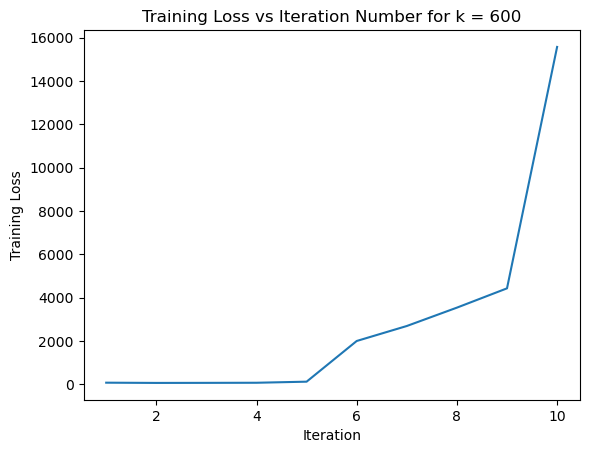

    k  Train Error  Test Error
0  10         0.99        0.43


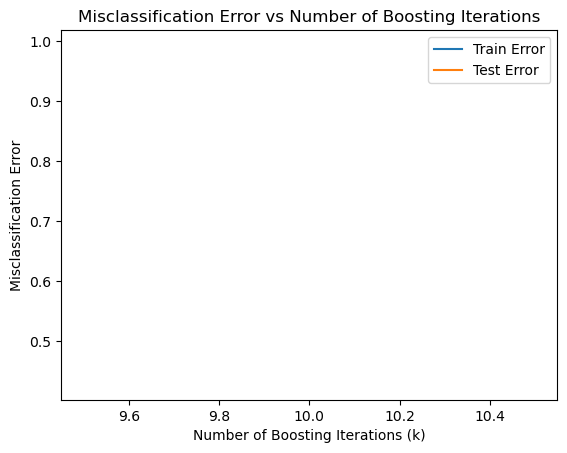

In [28]:
def loss_function(y, pred):
    y = 2 * y - 1
    return np.sum(np.log(1 + np.exp(-np.array(y) * np.array(pred))))

# Normalize the data
scaler = StandardScaler()
train_normalized = scaler.fit_transform(train)
test_normalized = scaler.transform(test)

# Define parameters
s = 0.001
mu = 300 
N_iter = 300
k_values = [10]
class_probabilities = np.zeros(len(true_train_labels)).reshape(-1, 1)

# Initialize lists to store results
train_losses = []
test_losses = []
train_errors = []
test_errors = []
best_lin_models = []

train_labels = (true_train_labels + 1) / 2

for k in k_values:
    train_losses_iter = []
    for _ in range(k):
        best_loss = float('inf')
        for feature_idx in range(train.shape[1]):
            # Fit univariate linear regressor
            X_feature = np.array(train.iloc[:, feature_idx]).reshape(-1, 1)
            exp_term = -1*np.array(class_probabilities)
            exp_term = np.clip(exp_term, -500, 500)  # Limit the range of the exponent to prevent overflow
            p = np.ones(len(train_labels)).reshape(-1,1) / (np.ones(len(train_labels)).reshape(-1,1) + np.exp(exp_term))
            w = p*(np.ones(len(train_labels)).reshape(-1,1) - p)
            # Handle division by zero or close to zero values in w
            w_mask = np.isclose(w, 0)
            w[w_mask] = 1  # Replace zero or close to zero values with 1
            
            z = np.zeros_like(train_labels)  # Initialize z array
            z[~w_mask] = ((np.array(train_labels)[~w_mask]) - p[~w_mask]) / w[~w_mask]
            
            temp_x = X_feature * w.reshape(-1, 1)  # Reshape w to match the shape of X_feature
            lr = LinearRegression().fit(temp_x, z)
            pred = lr.predict(X_feature)

            # Calculate loss
            loss = loss_function(train_labels, pred)
            if loss < best_loss:
                best_loss_index = feature_idx
                #print("better :)")
                best_loss = loss
                best_predictor = lr

        train.drop(axis = 1, columns = [best_loss_index])
        train_losses_iter.append(loss_function(train_labels, class_probabilities))  # Append the training loss at each iteration
        # Update class probabilities
        class_probabilities += best_predictor.predict(np.array(train.iloc[:, best_loss_index]).reshape(-1,1))
        
    train_losses.append(train_losses_iter)
    # Calculate training and test loss
    train_loss = loss_function(train_labels, class_probabilities)
    test_loss = loss_function(test_labels, class_probabilities)

    # Calculate training and test error
    train_pred = np.sign(class_probabilities)
    test_pred = np.sign(class_probabilities)
    train_error = 1 - accuracy_score(train_labels, train_pred)
    test_error = 1 - accuracy_score(test_labels, test_pred)
        
    train_losses.append(train_losses_iter)  # Append the list of training losses for this k to train_losses

    test_losses.append(test_loss)
    train_errors.append(train_error)
    test_errors.append(test_error)
    print(f"{k} done")

# Plot training loss vs iteration number for k = 600
plt.plot(range(1, 11), train_losses[-1])
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iteration Number for k = 600')
plt.show()

# Report misclassification errors on the training and test sets for all values of k
error_table = pd.DataFrame({'k': k_values, 'Train Error': train_errors, 'Test Error': test_errors})
print(error_table)

# Plot misclassification errors on the training and test sets vs k
plt.plot(k_values, train_errors, label='Train Error')
plt.plot(k_values, test_errors, label='Test Error')
plt.xlabel('Number of Boosting Iterations (k)')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Error vs Number of Boosting Iterations')
plt.legend()
plt.show()

In [ ]:
class LogitBoostUnivariate:
    def __init__(self, n_iter=100):
        self.n_iter = n_iter
        self.learners = []
        self.losses = []  # To store the loss at each iteration

    def fit(self, X, y):
        X = X.values if hasattr(X, 'values') else X
        y = y.values if hasattr(y, 'values') else y
        y = 2 * y - 1  # Convert labels to {−1, 1}
        F = np.zeros(len(y))
        for m in range(self.n_iter):
            best_learner = None
            best_loss = np.inf
            p = 1 / (1 + np.exp(-F))
            w = p * (1 - p)
            y = y if isinstance(y, np.ndarray) else y.to_numpy()
            p = p if isinstance(p, np.ndarray) else p.to_numpy()
            w = w if isinstance(w, np.ndarray) else w.to_numpy()
            z = (y - p) / w
            for j in range(X.shape[1]):
                Xj = X[:, j].reshape(-1, 1)
                learner = LinearRegression()
                try:
                    learner.fit(Xj, z, sample_weight=w)
                except ValueError:
                    continue
                Fj = learner.predict(Xj)
                loss = log_loss(y, 1 / (1 + np.exp(-F - Fj)), sample_weight=w)
                if loss < best_loss:
                    best_loss = loss
                    best_learner = (learner, j)
            self.learners.append(best_learner)
            self.losses.append(best_loss)
            F += best_learner[0].predict(X[:, best_learner[1]].reshape(-1, 1))

    def predict_proba(self, X):
        F = np.zeros(X.shape[0])
        for learner, feature in self.learners:
            F += learner.predict(X[:, feature].reshape(-1, 1))
        return 1 / (1 + np.exp(-F))

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

# Training LogitBoost classifiers with different numbers of iterations
iterations = [10, 30, 100, 300, 600]
errors_train = []
errors_test = []

for n_iter in iterations:
    model = LogitBoostUnivariate(n_iter=n_iter)
    model.fit(train, train_labels)
    
    # Predictions
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    # Errors
    error_train = 1 - accuracy_score(train_labels, pred_train)
    error_test = 1 - accuracy_score(test_labels, pred_test)
    errors_train.append(error_train)
    errors_test.append(error_test)

    # Plotting training loss for k = 600
    if n_iter == 600:
        plt.figure(figsize=(10, 6))
        plt.plot(model.losses, label='Training Loss')
        plt.title('Training Loss vs Iteration Number')
        plt.xlabel('Iteration Number')
        plt.ylabel('Training Loss')
        plt.legend()
        plt.show()

# Plotting misclassification errors vs k
plt.figure(figsize=(10, 6))
plt.plot(iterations, errors_train, label='Training Error', marker='o')
plt.plot(iterations, errors_test, label='Test Error', marker='o')
plt.title('Misclassification Errors vs Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Misclassification Error')
plt.legend()
plt.show()

# ROC curves for k = 300
model_300 = LogitBoostUnivariate(n_iter=300)
model_300.fit(train, train_labels)

# Predict probabilities
proba_train = model_300.predict_proba(train)
proba_test = model_300.predict_proba(test)

# Calculate ROC curve and AUC
fpr_train, tpr_train, _ = roc_curve(train_labels, proba_train)
fpr_test, tpr_test, _ = roc_curve(test_labels, proba_test)
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plotting ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
data_direc = os.getcwd() + "/"
if platform.system() == "Windows":
    data_direc = data_direc.replace("/", "\\")
train = pd.read_csv(data_direc + "gisette_train.csv")
train_labels = pd.read_csv(data_direc + "gisette_train_labels.csv")
test = pd.read_csv(data_direc + "gisette_valid.csv")
test_labels = pd.read_csv(data_direc + "gisette_valid_labels.csv")
train = np.delete(train, 5000, axis=1)
test = np.delete(test, 5000, axis=1)

In [ ]:
data_direc = os.getcwd() + "/"
if platform.system() == "Windows":
    data_direc = data_direc.replace("/", "\\")
train = pd.read_csv(data_direc + "gisette_train.csv")
train_labels = pd.read_csv(data_direc + "gisette_train_labels.csv")
test = pd.read_csv(data_direc + "gisette_valid.csv")
test_labels = pd.read_csv(data_direc + "gisette_valid_labels.csv")
train = np.delete(train, 5000, axis=1)
test = np.delete(test, 5000, axis=1)